In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import product
import os

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
train = pd.read_csv('/Users/qiongwu/git/qw257/257_group_proj/data/sales_train.csv')
test = pd.read_csv('/Users/qiongwu/git/qw257/257_group_proj/data/test.csv')
shops = pd.read_csv('/Users/qiongwu/git/qw257/257_group_proj/data/shops.csv')
cats = pd.read_csv('/Users/qiongwu/git/qw257/257_group_proj/data/item_categories.csv')
items = pd.read_csv('/Users/qiongwu/git/qw257/257_group_proj/data/items.csv')

In [4]:
len(train.item_id.unique())

21807

https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3

# Data Cleaning

1. Remove Outliers

<AxesSubplot:xlabel='item_price'>

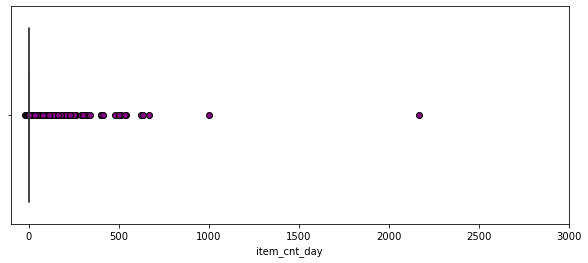

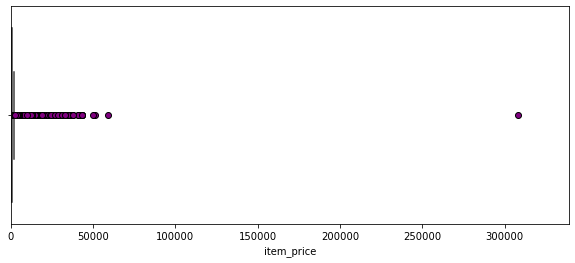

In [5]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [6]:
train = train[(train.item_price < 300000 ) & (train.item_cnt_day < 1000)]

In [7]:
# remove negative price and sales count
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

2. Cleaning Shop Data

Several of the shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [8]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [9]:
# Clean up some shop names and add 'city' and 'category' to shops df.

shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [10]:
# Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,other
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [11]:
# encode shop category and city using labelencoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]
shops

,shop_id,shop_category,shop_city
0,0,0,29
1,1,4,29
2,2,4,0
3,3,2,1
4,4,4,2
5,5,3,3
6,6,0,4
7,7,3,4
8,8,3,4
9,9,0,5


3. Cleaning Item Category Data

In [12]:
# split the category name and extract category type
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
cats.head()

,item_category_name,item_category_id,type_code,category
0,PC - Гарнитуры/Наушники,0,PC,NaN
1,Аксессуары - PS2,1,Аксессуары,Игры
2,Аксессуары - PS3,2,Аксессуары,Игры
3,Аксессуары - PS4,3,Аксессуары,Игры
4,Аксессуары - PSP,4,Аксессуары,Игры


In [13]:
# If a category type has >=5 categories, make it a type otherwise make it etc
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")
cats

,item_category_name,item_category_id,type_code,category
0,PC - Гарнитуры/Наушники,0,etc,NaN
1,Аксессуары - PS2,1,Аксессуары,Игры
2,Аксессуары - PS3,2,Аксессуары,Игры
3,Аксессуары - PS4,3,Аксессуары,Игры
4,Аксессуары - PSP,4,Аксессуары,Игры
...,...,...,...,...
79,Служебные,79,etc,NaN
80,Служебные - Билеты,80,etc,NaN
81,Чистые носители (шпиль),81,etc,NaN
82,Чистые носители (штучные),82,etc,NaN


In [14]:
# encode type_code using label encoder
cats.type_code = LabelEncoder().fit_transform(cats.type_code)

# extract subtype from category name and encode it
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]
cats

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1
...,...,...,...
79,79,54,0
80,80,25,0
81,81,62,0
82,82,63,0


4. Cleaning Item Data

In [15]:
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [16]:
# Clean item names.

# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - remove the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

<ipython-input-16-2adb2ea769eb>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
<ipython-input-16-2adb2ea769eb>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name3"] = items.item_name.str.split("(", 1).str
<ipython-input-16-2adb2ea769eb>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
<ipython-input-16-2adb2ea769eb>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()


In [17]:
items.head(20)

,item_name,item_id,item_category_id,name1,name2,name3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d
5,новые американские граффити,5,40,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ,0,uni d
6,удар по воротам,6,40,***УДАР ПО ВОРОТАМ,0,uni d
7,удар по воротам 2,7,40,***УДАР ПО ВОРОТАМ-2,0,uni d
8,чай с муссолини d,8,40,***ЧАЙ С МУССОЛИНИ D,0,0
9,шугарлэндский экспресс,9,40,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС,0,uni d


In [18]:
# Clean item type (type populated based on name2)

items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

items.head(20)

,item_name,item_id,item_category_id,name1,name2,name3,type
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d,0
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0,pc
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d,0
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d,0
4,коробка,4,40,***КОРОБКА,0,стекло d,0
5,новые американские граффити,5,40,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ,0,uni d,0
6,удар по воротам,6,40,***УДАР ПО ВОРОТАМ,0,uni d,0
7,удар по воротам 2,7,40,***УДАР ПО ВОРОТАМ-2,0,uni d,0
8,чай с муссолини d,8,40,***ЧАЙ С МУССОЛИНИ D,0,0,0
9,шугарлэндский экспресс,9,40,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС,0,uni d,0


In [19]:
# how many items in each item type
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
group_sum

,type,item_id
0,0,17661
1,5c5,1
2,5c7,2
3,5f4,1
4,6dv,1
5,6jv,1
6,6l6,1
7,android,3
8,hm3,1
9,j72,4


In [20]:
# if a type has less than 40 items, make them into one single type called other
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)

items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [21]:
# encode name2 and name3 
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

# name2 = string inside square brackets []
# name3 = string inside round brackets ()
# name1 = string on left of brackets
# item_name = string on left of brackets

# not sure why dropping these two columns
items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


# Preprocessing

In [22]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [23]:
#if an item sles less than 10 in 34 months, then drop the item for further training
item_head = train.groupby('item_id')['item_cnt_day'].sum()
item_head.shape

(21806,)

In [24]:
item_head = item_head.loc[item_head.values > 10]
item_head

item_id
27         42.0
28         85.0
29         13.0
30       2090.0
31       1440.0
          ...  
22162     700.0
22163      75.0
22164     494.0
22166     348.0
22167    1321.0
Name: item_cnt_day, Length: 15110, dtype: float64

In [25]:
shop_ids = list(set(train.shop_id)|set(test.shop_id))
item_ids = list(set(item_head.index)|set(test.item_id))
print(len(shop_ids))
print(len(item_ids))

57
15999


In [26]:
# Create a matrix df with every combination of month, shop and item.
months = range(34)
cols  = ["date_block_num", "shop_id", "item_id"]
matrix_ = list(product(months, shop_ids, item_ids )) 
len(matrix_)



31006062

In [27]:
matrix = pd.DataFrame(data = matrix_, columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
matrix

,date_block_num,shop_id,item_id
0,0,2,27
1,0,2,28
2,0,2,29
3,0,2,30
4,0,2,31
...,...,...,...
31006057,33,59,22162
31006058,33,59,22163
31006059,33,59,22164
31006060,33,59,22166


In [28]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,0.0,0.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...,...
2935840,10.10.2015,33,25,7409,299.00,1.0,299.00
2935841,09.10.2015,33,25,7460,299.00,1.0,299.00
2935842,14.10.2015,33,25,7459,349.00,1.0,349.00
2935843,22.10.2015,33,25,7440,299.00,1.0,299.00


In [29]:
# get monthly item count
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"], "revenue":"sum"} )
group.columns = ["item_cnt_month", "revenue_month"]
group.reset_index( inplace = True)
group

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,798.0
...,...,...,...,...,...
1609117,33,59,22087,6.0,714.0
1609118,33,59,22088,2.0,238.0
1609119,33,59,22091,1.0,179.0
1609120,33,59,22100,1.0,629.0


In [30]:
# add monthly item count to matrix
matrix = pd.merge( matrix, group, on = cols, how = "left" )

In [31]:
matrix = matrix.fillna(0)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month
0,0,2,27,1.0,2499.0
1,0,2,28,0.0,0.0
2,0,2,29,0.0,0.0
3,0,2,30,0.0,0.0
4,0,2,31,0.0,0.0
...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0
31006058,33,59,22163,0.0,0.0
31006059,33,59,22164,0.0,0.0
31006060,33,59,22166,0.0,0.0


In [32]:
# Create a test set for month 34.
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [33]:
# Add shop, items and categories data onto matrix df.
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code
0,0,2,27,1.0,2499.0,4,0,19,76,42,10,3
1,0,2,28,0.0,0.0,4,0,30,107,42,55,3
2,0,2,29,0.0,0.0,4,0,23,123,42,16,3
3,0,2,30,0.0,0.0,4,0,40,4,42,4,5
4,0,2,31,0.0,0.0,4,0,37,4,562,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,4,5
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,4,5
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,1,5
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,61,6


# Feature Engineering

Add additional features related to item count

In [34]:
def add_feature(df, group_by, col, col_name):
  group = df.groupby( group_by ).agg({col : ["mean"]})
  group.columns = [col_name]
  group.reset_index(inplace = True)
  df = pd.merge(df, group, on = group_by, how = "left")
  df[col_name] = df[col_name].astype(np.float16)
  return df

In [35]:
# average item count per month-shop-item_cat 
matrix = add_feature(matrix, ['date_block_num', 'shop_id', 'item_category_id'], "item_cnt_month", "month_shop_itemcat_avg_cnt")

In [36]:
# average item count per month-shop-item_type
matrix = add_feature(matrix, ['date_block_num', 'shop_id', 'type_code'], "item_cnt_month", "month_shop_itemtype_avg_cnt")

In [37]:
# # average item count per month-shop_cat-item 
# matrix = add_feature(matrix, ['date_block_num', 'shop_category', 'item_id'], "item_cnt_month", "month_shopcat_item_avg_cnt")

In [38]:
# # average item count per month-shop_cat-item_cat 
# matrix = add_feature(matrix, ['date_block_num', 'shop_category', 'item_category_id'], "item_cnt_month", "month_shopcat_itemcat_avg_cnt")

In [39]:
# average item count per month-city-item
matrix = add_feature(matrix, ['date_block_num', 'shop_city', 'item_id'], "item_cnt_month", "month_city_item_avg_cnt")

In [40]:
# average item count per month-city-item_cat
matrix = add_feature(matrix, ['date_block_num', 'shop_city', 'item_category_id'], "item_cnt_month", "month_city_itemcat_avg_cnt")

In [41]:
# average item count per month-shop
matrix = add_feature(matrix, ['date_block_num', 'shop_id'], "item_cnt_month", "month_shop_avg_cnt")

In [42]:
# average item count per month-shop_cat
matrix = add_feature(matrix, ['date_block_num', 'shop_category'], "item_cnt_month", "month_shopcat_avg_cnt")

In [43]:
# average item count per month-item
matrix = add_feature(matrix, ['date_block_num', 'item_id'], "item_cnt_month", "month_item_avg_cnt")

In [44]:
# average item count per month-item_cat
matrix = add_feature(matrix, ['date_block_num', 'item_category_id'], "item_cnt_month", "month_itemcat_avg_cnt")

In [45]:
# average item count per month-city
matrix = add_feature(matrix, ['date_block_num', 'shop_city'], "item_cnt_month", "month_city_avg_cnt")

In [46]:
# average item count per month
matrix = add_feature(matrix, ['date_block_num'], "item_cnt_month", "month_avg_cnt")

In [47]:
# average item count per item
matrix = add_feature(matrix, ['item_id'], "item_cnt_month", "item_avg_cnt")

In [48]:
# average item count per shop
matrix = add_feature(matrix, ['shop_id'], "item_cnt_month", "shop_avg_cnt")

In [49]:
# matrix

Add additional features related to date to capture cycle and seasonality


In [50]:
# month
matrix['month'] = matrix['date_block_num']%12
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month
0,0,2,27,1.0,2499.0,4,0,19,76,42,...,0.237549,0.070312,0.188354,0.122803,0.326660,0.070312,0.141968,0.021667,0.056244,0
1,0,2,28,0.0,0.0,4,0,30,107,42,...,0.440918,0.070312,0.188354,0.140381,0.775391,0.070312,0.141968,0.043854,0.056244,0
2,0,2,29,0.0,0.0,4,0,23,123,42,...,0.090881,0.070312,0.188354,0.087708,0.190674,0.070312,0.141968,0.006706,0.056244,0
3,0,2,30,0.0,0.0,4,0,40,4,42,...,0.040771,0.070312,0.188354,0.000000,0.141968,0.070312,0.141968,1.078125,0.056244,0
4,0,2,31,0.0,0.0,4,0,37,4,562,...,0.034729,0.070312,0.188354,0.000000,0.071533,0.070312,0.141968,0.743164,0.056244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,0.019653,0.049500,0.061127,0.175415,0.033020,0.049500,0.074951,0.361084,0.090088,9
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.019653,0.049500,0.061127,0.456055,0.033020,0.049500,0.074951,0.038696,0.090088,9
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,0.042236,0.049500,0.061127,0.263184,0.048584,0.049500,0.074951,0.254883,0.090088,9
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.000000,0.049500,0.061127,0.192993,0.095947,0.049500,0.074951,0.179565,0.090088,9


In [51]:
# year
import math
matrix['year'] = matrix['date_block_num']/12
matrix['year'] = matrix.year.apply(lambda x: math.floor(x))
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year
0,0,2,27,1.0,2499.0,4,0,19,76,42,...,0.070312,0.188354,0.122803,0.326660,0.070312,0.141968,0.021667,0.056244,0,0
1,0,2,28,0.0,0.0,4,0,30,107,42,...,0.070312,0.188354,0.140381,0.775391,0.070312,0.141968,0.043854,0.056244,0,0
2,0,2,29,0.0,0.0,4,0,23,123,42,...,0.070312,0.188354,0.087708,0.190674,0.070312,0.141968,0.006706,0.056244,0,0
3,0,2,30,0.0,0.0,4,0,40,4,42,...,0.070312,0.188354,0.000000,0.141968,0.070312,0.141968,1.078125,0.056244,0,0
4,0,2,31,0.0,0.0,4,0,37,4,562,...,0.070312,0.188354,0.000000,0.071533,0.070312,0.141968,0.743164,0.056244,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,0.049500,0.061127,0.175415,0.033020,0.049500,0.074951,0.361084,0.090088,9,2
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.049500,0.061127,0.456055,0.033020,0.049500,0.074951,0.038696,0.090088,9,2
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,0.049500,0.061127,0.263184,0.048584,0.049500,0.074951,0.254883,0.090088,9,2
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.049500,0.061127,0.192993,0.095947,0.049500,0.074951,0.179565,0.090088,9,2


In [52]:
# season 
season = pd.Series([0,0,0,1,1,1,2,2,2,3,3,3])
matrix["season"] = matrix["month"].map(season).astype(np.int8)

In [53]:
# number of days in the month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add additional features related to price

In [54]:
# avg price per month-item
group = train.groupby( ['date_block_num', 'item_id'] ).agg({"item_price" : ["mean"]})
group.columns = ["month_avg_item_price"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ['date_block_num', 'item_id'], how = "left")
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,month_avg_item_price
0,0,2,27,1.0,2499.0,4,0,19,76,42,...,0.326660,0.070312,0.141968,0.021667,0.056244,0,0,0,31,2325.000000
1,0,2,28,0.0,0.0,4,0,30,107,42,...,0.775391,0.070312,0.141968,0.043854,0.056244,0,0,0,31,549.000000
2,0,2,29,0.0,0.0,4,0,23,123,42,...,0.190674,0.070312,0.141968,0.006706,0.056244,0,0,0,31,2397.500000
3,0,2,30,0.0,0.0,4,0,40,4,42,...,0.141968,0.070312,0.141968,1.078125,0.056244,0,0,0,31,NaN
4,0,2,31,0.0,0.0,4,0,37,4,562,...,0.071533,0.070312,0.141968,0.743164,0.056244,0,0,0,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,0.033020,0.049500,0.074951,0.361084,0.090088,9,2,3,31,349.000000
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.033020,0.049500,0.074951,0.038696,0.090088,9,2,3,31,162.698400
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,0.048584,0.049500,0.074951,0.254883,0.090088,9,2,3,31,549.000000
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.095947,0.049500,0.074951,0.179565,0.090088,9,2,3,31,150.000000


In [55]:
# avg price per year-item
year_price = train[['date', 'item_id','item_price']]
year_price['year'] = year_price.apply(lambda row: int(row.date.split('.')[2])-2013, axis = 1)
year_price

<ipython-input-55-cf210e7a9182>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_price['year'] = year_price.apply(lambda row: int(row.date.split('.')[2])-2013, axis = 1)


,date,item_id,item_price,year
0,02.01.2013,22154,999.00,0
1,03.01.2013,2552,899.00,0
2,05.01.2013,2552,899.00,0
3,06.01.2013,2554,1709.05,0
4,15.01.2013,2555,1099.00,0
...,...,...,...,...
2935840,10.10.2015,7409,299.00,2
2935841,09.10.2015,7460,299.00,2
2935842,14.10.2015,7459,349.00,2
2935843,22.10.2015,7440,299.00,2


In [56]:
group = year_price.groupby( ['year', 'item_id'] ).agg({"item_price" : ["mean"]})
group.columns = ["year_avg_item_price"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ['year', 'item_id'], how = "left")
matrix["year_avg_item_price"] = matrix['year_avg_item_price'].astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,month_avg_item_price,year_avg_item_price
0,0,2,27,1.0,2499.0,4,0,19,76,42,...,0.070312,0.141968,0.021667,0.056244,0,0,0,31,2325.000000,1594.000
1,0,2,28,0.0,0.0,4,0,30,107,42,...,0.070312,0.141968,0.043854,0.056244,0,0,0,31,549.000000,311.250
2,0,2,29,0.0,0.0,4,0,23,123,42,...,0.070312,0.141968,0.006706,0.056244,0,0,0,31,2397.500000,1802.000
3,0,2,30,0.0,0.0,4,0,40,4,42,...,0.070312,0.141968,1.078125,0.056244,0,0,0,31,NaN,366.500
4,0,2,31,0.0,0.0,4,0,37,4,562,...,0.070312,0.141968,0.743164,0.056244,0,0,0,31,NaN,662.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,0.049500,0.074951,0.361084,0.090088,9,2,3,31,349.000000,382.250
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.049500,0.074951,0.038696,0.090088,9,2,3,31,162.698400,164.625
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,0.049500,0.074951,0.254883,0.090088,9,2,3,31,549.000000,713.500
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.049500,0.074951,0.179565,0.090088,9,2,3,31,150.000000,150.000


In [57]:
# avg price per year-item_cat
#year_avg_cat_price
year_cat_price = pd.merge(year_price,items[['item_id','item_category_id']], on = 'item_id', how = 'left')

In [58]:
year_cat_price = year_cat_price[['item_price', 'year', 'item_category_id']].groupby( ['year', 'item_category_id'] ).agg({"item_price" : ["mean"]})
year_cat_price.columns = year_cat_price.columns.droplevel()
year_cat_price = year_cat_price.reset_index()
year_cat_price.columns = ['year', 'item_category_id', 'year_avg_cat_price']

In [59]:
#year_cat_price

In [60]:
matrix = pd.merge(matrix, year_cat_price, on = ['year','item_category_id'], how = 'left')

In [61]:
# avg item price
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)
matrix = pd.merge( matrix,group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix['item_avg_item_price'].astype(np.float16)

Delta features

In [62]:
#Lag features for change in price values
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [63]:
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["month_avg_item_price"] )

month_avg_item_price


In [64]:
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["month_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

In [65]:
#Function to select just one change in price compared to the rest 3
def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

In [66]:
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix['delta_price_lag'].astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

In [67]:
#Drop unwanted features 
features_to_drop = ["item_avg_item_price", "month_avg_item_price"]
for i in lags:
    features_to_drop.append("month_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)

In [68]:
#Lag features for item_cnt_month
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature( matrix, lags, ["item_cnt_month"] )
matrix

item_cnt_month


,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,days,year_avg_item_price,year_avg_cat_price,delta_price_lag,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6
0,0,2,27,1.0,2499.0,4,0,19,76,42,...,31,1594.000,1514.601304,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,28,0.0,0.0,4,0,30,107,42,...,31,311.250,456.299900,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,29,0.0,0.0,4,0,23,123,42,...,31,1802.000,1543.248943,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,30,0.0,0.0,4,0,40,4,42,...,31,366.500,248.578945,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,31,0.0,0.0,4,0,37,4,562,...,31,662.500,442.218438,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,31,382.250,271.537594,-0.085815,0.0,1.0,0.0,0.0,1.0,1.0
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,31,164.625,271.537594,0.026581,0.0,0.0,0.0,0.0,0.0,0.0
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,31,713.500,451.071719,-0.230591,0.0,0.0,1.0,0.0,0.0,2.0
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,31,150.000,192.252784,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Other features trend, first sales, last sell shops,…

In [69]:
#Revenue for shops based on date
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)
matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


In [70]:
# Shop avg revenue
group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )
matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)

In [71]:
#Change in revenue - how current month revenue changes to global average
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)


In [72]:
matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)

delta_revenue


In [73]:
#Remove unwanted features after calculating the delta 
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

In [74]:
#Item first sold in shop
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
#Item first sold globally
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

In [75]:
#Removing first 6 months as they dont have lag values
matrix = matrix[matrix["date_block_num"] > 5]

In [76]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,delta_price_lag,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,delta_revenue_lag_1,item_shop_first_sale,item_first_sale
5471658,6,2,27,0.0,0.0,4,0,19,76,42,...,-0.043121,0.0,0.0,0.0,0.0,0.0,1.0,50141.062500,6,6
5471659,6,2,28,0.0,0.0,4,0,30,107,42,...,-0.038696,0.0,0.0,0.0,0.0,0.0,0.0,50141.062500,6,6
5471660,6,2,29,0.0,0.0,4,0,23,123,42,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,50141.062500,6,6
5471661,6,2,30,0.0,0.0,4,0,40,4,42,...,0.232422,1.0,0.0,0.0,1.0,0.0,0.0,50141.062500,6,6
5471662,6,2,31,0.0,0.0,4,0,37,4,562,...,0.208252,0.0,0.0,1.0,1.0,4.0,0.0,50141.062500,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,-0.085815,0.0,1.0,0.0,0.0,1.0,1.0,66717.367188,33,33
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.026581,0.0,0.0,0.0,0.0,0.0,0.0,66717.367188,33,33
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,-0.230591,0.0,0.0,1.0,0.0,0.0,2.0,66717.367188,33,33
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,66717.367188,33,33


Adding the number of Russian holidays per month as a feature

In [77]:
holidays_in_month = [7, 1, 2, 1, 6, 2, 0, 0, 0, 0, 1, 1]
holidays_next_month = [1, 2, 1, 6, 2, 0, 0, 0, 0, 1, 1, 7]
test_holidays = matrix.copy()

In [78]:
test_holidays["holidays_in_month"] = 0
test_holidays["holidays_next_month"] = 0

for i in range(0, 12):
    test_holidays['holidays_in_month'] = np.where(test_holidays['date_block_num']%12 == i, holidays_in_month[i], test_holidays['holidays_in_month'])

for i in range(0, 12):
    test_holidays['holidays_next_month'] = np.where(test_holidays['date_block_num']%12 == i, holidays_next_month[i], test_holidays['holidays_next_month'])

matrix = test_holidays
del test_holidays
matrix

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,delta_revenue_lag_1,item_shop_first_sale,item_first_sale,holidays_in_month,holidays_next_month
5471658,6,2,27,0.0,0.0,4,0,19,76,42,...,0.0,0.0,0.0,0.0,1.0,50141.062500,6,6,0,0
5471659,6,2,28,0.0,0.0,4,0,30,107,42,...,0.0,0.0,0.0,0.0,0.0,50141.062500,6,6,0,0
5471660,6,2,29,0.0,0.0,4,0,23,123,42,...,0.0,0.0,0.0,0.0,0.0,50141.062500,6,6,0,0
5471661,6,2,30,0.0,0.0,4,0,40,4,42,...,0.0,0.0,1.0,0.0,0.0,50141.062500,6,6,0,0
5471662,6,2,31,0.0,0.0,4,0,37,4,562,...,0.0,1.0,1.0,4.0,0.0,50141.062500,6,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006057,33,59,22162,0.0,0.0,4,30,40,4,42,...,1.0,0.0,0.0,1.0,1.0,66717.367188,33,33,0,1
31006058,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.0,0.0,0.0,0.0,0.0,66717.367188,33,33,0,1
31006059,33,59,22164,0.0,0.0,4,30,37,4,562,...,0.0,1.0,0.0,0.0,2.0,66717.367188,33,33,0,1
31006060,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.0,0.0,0.0,0.0,0.0,66717.367188,33,33,0,1


In [79]:
#Generate label columns
data = matrix.fillna(0).copy()
right_df = data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
right_df['pre_block'] = right_df['date_block_num'] -1
data = pd.merge(data, right_df, how = 'left', left_on = ['date_block_num', 'shop_id', 'item_id'], right_on= ['pre_block', 'shop_id', 'item_id'])
data.rename(columns = {'date_block_num_x':'date_block_num', 'item_cnt_month_x':'item_cnt_this_month', 'item_cnt_month_y':'item_cnt_next_month'}, inplace=True)

<ipython-input-79-4da36d08baa7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['pre_block'] = right_df['date_block_num'] -1


In [80]:
data.drop(columns = ['date_block_num_y', 'pre_block'], inplace = True)
data.fillna(0, inplace=True)

In [158]:
data

,date_block_num,shop_id,item_id,item_cnt_this_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,delta_revenue_lag_1,item_shop_first_sale,item_first_sale,holidays_in_month,holidays_next_month,item_cnt_next_month
0,6,2,27,0.0,0.0,4,0,19,76,42,...,0.0,0.0,0.0,1.0,50141.062500,6,6,0,0,0.0
1,6,2,28,0.0,0.0,4,0,30,107,42,...,0.0,0.0,0.0,0.0,50141.062500,6,6,0,0,0.0
2,6,2,29,0.0,0.0,4,0,23,123,42,...,0.0,0.0,0.0,0.0,50141.062500,6,6,0,0,0.0
3,6,2,30,0.0,0.0,4,0,40,4,42,...,0.0,1.0,0.0,0.0,50141.062500,6,6,0,0,0.0
4,6,2,31,0.0,0.0,4,0,37,4,562,...,1.0,1.0,4.0,0.0,50141.062500,6,6,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25534399,33,59,22162,0.0,0.0,4,30,40,4,42,...,0.0,0.0,1.0,1.0,66717.367188,33,33,0,1,0.0
25534400,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.0,0.0,0.0,0.0,66717.367188,33,33,0,1,0.0
25534401,33,59,22164,0.0,0.0,4,30,37,4,562,...,1.0,0.0,0.0,2.0,66717.367188,33,33,0,1,0.0
25534402,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.0,0.0,0.0,0.0,66717.367188,33,33,0,1,0.0


In [159]:
data

,date_block_num,shop_id,item_id,item_cnt_this_month,revenue_month,shop_category,shop_city,item_category_id,name2,name3,...,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,delta_revenue_lag_1,item_shop_first_sale,item_first_sale,holidays_in_month,holidays_next_month,item_cnt_next_month
0,6,2,27,0.0,0.0,4,0,19,76,42,...,0.0,0.0,0.0,1.0,50141.062500,6,6,0,0,0.0
1,6,2,28,0.0,0.0,4,0,30,107,42,...,0.0,0.0,0.0,0.0,50141.062500,6,6,0,0,0.0
2,6,2,29,0.0,0.0,4,0,23,123,42,...,0.0,0.0,0.0,0.0,50141.062500,6,6,0,0,0.0
3,6,2,30,0.0,0.0,4,0,40,4,42,...,0.0,1.0,0.0,0.0,50141.062500,6,6,0,0,0.0
4,6,2,31,0.0,0.0,4,0,37,4,562,...,1.0,1.0,4.0,0.0,50141.062500,6,6,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25534399,33,59,22162,0.0,0.0,4,30,40,4,42,...,0.0,0.0,1.0,1.0,66717.367188,33,33,0,1,0.0
25534400,33,59,22163,0.0,0.0,4,30,40,4,36,...,0.0,0.0,0.0,0.0,66717.367188,33,33,0,1,0.0
25534401,33,59,22164,0.0,0.0,4,30,37,4,562,...,1.0,0.0,0.0,2.0,66717.367188,33,33,0,1,0.0
25534402,33,59,22166,0.0,0.0,4,30,54,-85,42,...,0.0,0.0,0.0,0.0,66717.367188,33,33,0,1,0.0


In [160]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_this_month',
       'revenue_month', 'shop_category', 'shop_city', 'item_category_id',
       'name2', 'name3', 'subtype_code', 'type_code',
       'month_shop_itemcat_avg_cnt', 'month_shop_itemtype_avg_cnt',
       'month_city_item_avg_cnt', 'month_city_itemcat_avg_cnt',
       'month_shop_avg_cnt', 'month_shopcat_avg_cnt', 'month_item_avg_cnt',
       'month_itemcat_avg_cnt', 'month_city_avg_cnt', 'month_avg_cnt',
       'item_avg_cnt', 'shop_avg_cnt', 'month', 'year', 'season', 'days',
       'year_avg_item_price', 'year_avg_cat_price', 'delta_price_lag',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
       'delta_revenue_lag_1', 'item_shop_first_sale', 'item_first_sale',
       'holidays_in_month', 'holidays_next_month', 'item_cnt_next_month'],
      dtype='object')

In [204]:
# Create the training, validation, and testing datasets
# select_features = ['item_cnt_this_month',
#        'revenue_month', 'shop_city',
#        'type_code',
#        'month_shop_itemcat_avg_cnt', 'month_shop_itemtype_avg_cnt',
#        'month_city_item_avg_cnt', 'month_city_itemcat_avg_cnt',
#        'month_shop_avg_cnt', 'month_shopcat_avg_cnt', 'month_item_avg_cnt',
#        'month_itemcat_avg_cnt', 'month_city_avg_cnt', 'month_avg_cnt',
#        'item_avg_cnt', 'shop_avg_cnt', 'month', 'season',
#        'year_avg_item_price', 'delta_price_lag',
#        'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
#        'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
#        'delta_revenue_lag_1', 
#        'holidays_in_month', 'holidays_next_month']

feature_selected: ['revenue_month', 'shop_category', 'shop_city', 'item_category_id',
    'subtype_code', 'type_code', 'month', 'year',
    'season', 'days', 'delta_price_lag', 'item_cnt_month_lag_1',
    'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'delta_revenue_lag_1',
    'item_shop_first_sale', 'item_first_sale', 'holidays_in_month']

train = data.loc[data.date_block_num < 32]
valid = data.loc[data.date_block_num == 32]
testx = data.loc[data.date_block_num == 33]

X_train = train[select_features]
y_train = train.item_cnt_next_month
X_valid = valid[select_features]
y_valid = valid.item_cnt_next_month
X_testx = testx[select_features]
print(X_train.shape)
print(X_valid.shape)
print(X_testx.shape)

(23710518, 29)
(911943, 29)
(911943, 29)


In [205]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standarized=scaler.transform(X_train)
X_valid_standarized=scaler.transform(X_valid)
X_testx_standarized=scaler.transform(X_testx)

In [248]:
pca = PCA(n_components=16, svd_solver='full')
pca.fit(X_train_standarized)

PCA(n_components=16, svd_solver='full')

In [249]:
print(pca.explained_variance_ratio_.sum())

0.9036781371182151


In [95]:
X_train_pca = pca.transform(X_train_standarized)
X_valid_pca = pca.transform(X_valid_standarized)
X_testx_pca = pca.transform(X_testx_standarized)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.linear_model import LassoCV
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit_transform(X_train)
# lasso = LassoCV().fit(X_train, y_train)



In [ ]:
# print(lasso.coef_)
# print(X_train.columns)
# importance = np.abs(lasso.coef_)
# feature_names = np.array(X_train.columns)
# plt.figure(figsize=(15, 10))
# plt.bar(height=importance, x=feature_names)
# plt.xticks(feature_names, rotation='vertical')
# plt.title("Feature importances via coefficients")

# plt.show()

In [222]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [ ]:
# def baseline_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(13, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mse', optimizer='adam', metrics='mse')
# 	return model

In [132]:
from sklearn.metrics import mean_squared_error
def rmse(model, X_valid, y_valid = y_valid):
    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared = False)
    print(rmse)


In [133]:
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# model.save_weights(checkpoint_path.format(epoch=0))

In [134]:
def save_submission(test_pred, file_name, test = test):
    submission = pd.merge(test, test_pred, how = 'left', on = ['shop_id', 'item_id'] ) 
    submission.fillna(0, inplace=True)
    submission.loc[: , ['ID', 'item_cnt_month']].to_csv(file_name, index = None)

In [135]:
def pred_n_save(model, file_name, test = test, X_test = X_testx):
    index = X_test.index
    test_pred = model.predict(X_test)
    test_pred = pd.DataFrame(data = test_pred, index = index, columns = ['item_cnt_month'])
    test_pred
    pred = pd.concat([testx.loc[:, ['shop_id', 'item_id']], test_pred], axis = 1)
    pred.loc[pred['item_cnt_month'] < 0, 'item_cnt_month'] = 0
    submission = pd.merge(test, pred, how = 'left', on = ['shop_id', 'item_id'] ) 
    submission.fillna(0, inplace=True)
    submission.loc[: , ['ID', 'item_cnt_month']].to_csv(file_name, index = None)

In [ ]:
# pred_n_save(model_1, 'pred001.csv')

In [ ]:
# def larger_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(13, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'mse')
# 	return model

In [231]:
def base_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'mse')
    return model

In [250]:
def base_model_pca():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=X_train_pca.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'mse')
    return model

In [240]:
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(40, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'mse')
    return model

In [241]:
def deeper_model():
    # create model
    model = Sequential()
    model.add(Dense(40, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    # Compile mode
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'mse')
    return model
    

In [235]:
#Use basic model
model_1 = base_model()
model_1.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 20)                600       
_________________________________________________________________
dense_192 (Dense)            (None, 12)                252       
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 13        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [236]:
history1 = model_1.fit(X_train, y_train, validation_data = (X_valid, y_valid), batch_size = 5000, epochs=30, callbacks = [earlystopping])

Epoch 1/30
4743/4743 [==============================] - 12s 2ms/step - loss: 73851.1071 - mse: 73851.1071 - val_loss: 15.7200 - val_mse: 15.7200
Epoch 2/30
4743/4743 [==============================] - 8s 2ms/step - loss: 335.4857 - mse: 335.4857 - val_loss: 5.9233 - val_mse: 5.9233
Epoch 3/30
4743/4743 [==============================] - 9s 2ms/step - loss: 1183.1961 - mse: 1183.1961 - val_loss: 2272.6057 - val_mse: 2272.6057
Epoch 4/30
4743/4743 [==============================] - 8s 2ms/step - loss: 177.5015 - mse: 177.5015 - val_loss: 34.4849 - val_mse: 34.4849
Epoch 5/30
4743/4743 [==============================] - 8s 2ms/step - loss: 95.8634 - mse: 95.8634 - val_loss: 2.6474 - val_mse: 2.6474
Epoch 6/30
4743/4743 [==============================] - 9s 2ms/step - loss: 53.6956 - mse: 53.6956 - val_loss: 5.8117 - val_mse: 5.8117
Epoch 7/30
4743/4743 [==============================] - 9s 2ms/step - loss: 97.9874 - mse: 97.9874 - val_loss: 2.3997 - val_mse: 2.3997
Epoch 8/30
4743/4743 [=

In [237]:
rmse(model_1, X_valid)
pred_n_save(model_1, 'pred320_base_fs2_20cb.csv')

1.0825246233992016


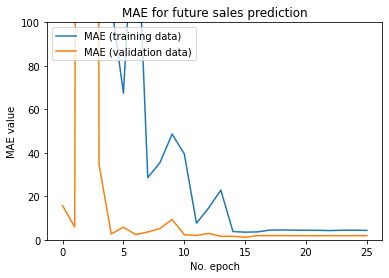

In [272]:
# Plot history: MAE
plt.plot(history1.history['loss'], label='MAE (training data)')
plt.plot(history1.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for future sales prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

In [171]:
#Use the wider model

In [242]:
model_2 = wider_model()
model_2.summary()
history2 = model_2.fit(X_train, y_train, validation_data = (X_valid, y_valid), batch_size = 5000, epochs=30, callbacks = [earlystopping])

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_194 (Dense)            (None, 40)                1200      
_________________________________________________________________
dense_195 (Dense)            (None, 60)                2460      
_________________________________________________________________
dense_196 (Dense)            (None, 1)                 61        
Total params: 3,721
Trainable params: 3,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4743/4743 [==============================] - 17s 3ms/step - loss: 249511.7680 - mse: 249511.7680 - val_loss: 170.1826 - val_mse: 170.1826
Epoch 2/30
4743/4743 [==============================] - 14s 3ms/step - loss: 679.6163 - mse: 679.6163 - val_loss: 10.6485 - val_mse: 10.6485
Epoch 3/30
4743/4743 [==============================] - 14s 3ms/step - loss: 417.1007 - mse

In [243]:
rmse(model_2, X_valid)
pred_n_save(model_2, 'pred330_wider_fs2_20cb.csv')

1.0789055434093868


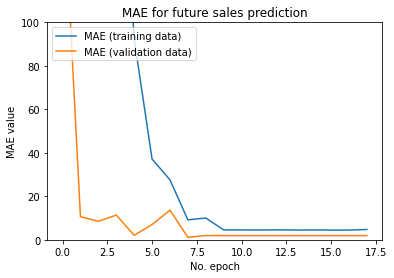

In [271]:
# Plot history: MAE
plt.plot(history2.history['loss'], label='MAE (training data)')
plt.plot(history2.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for future sales prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

In [244]:
#Use the deeper model
model_3 = deeper_model()
model_3.summary()
history3 = model_3.fit(X_train, y_train, validation_data = (X_valid, y_valid), batch_size = 5000, epochs=30, callbacks = [earlystopping])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 40)                1200      
_________________________________________________________________
dense_198 (Dense)            (None, 60)                2460      
_________________________________________________________________
dense_199 (Dense)            (None, 60)                3660      
_________________________________________________________________
dense_200 (Dense)            (None, 12)                732       
_________________________________________________________________
dropout_5 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 13        
Total params: 8,065
Trainable params: 8,065
Non-trainable params: 0
___________________________________________________

In [245]:
rmse(model_3, X_valid)
pred_n_save(model_3, 'pred330_deeper_fs2_20cb.csv')

1.3833449779711464


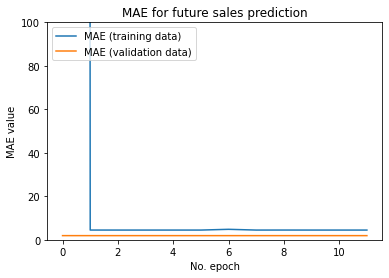

In [273]:
# Plot history: MAE
plt.plot(history3.history['loss'], label='MAE (training data)')
plt.plot(history3.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for future sales prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

In [251]:
#Use base model train with X_train_pca(explained_variance_ratio = 90%)
model_4 = base_model_pca()
model_4.summary()
history4 = model_4.fit(X_train_pca, y_train, validation_data = (X_valid_pca, y_valid), batch_size = 5000, epochs=30, callbacks = [earlystopping])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 20)                200       
_________________________________________________________________
dense_203 (Dense)            (None, 12)                252       
_________________________________________________________________
dense_204 (Dense)            (None, 1)                 13        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4743/4743 [==============================] - 7s 1ms/step - loss: 2.7212 - mse: 2.7212 - val_loss: 4.3864 - val_mse: 4.3864
Epoch 2/30
4743/4743 [==============================] - 5s 1ms/step - loss: 2.6803 - mse: 2.6803 - val_loss: 4.1200 - val_mse: 4.1200
Epoch 3/30
4743/4743 [==============================] - 5s 1ms/step - loss: 2.2461 - mse: 2.2461 - val_loss: 4.5218 -

In [253]:
rmse(model_4, X_valid_pca)

1.9821737083736255


In [260]:
def test_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'mse')
    return model

In [261]:
model_5 = test_model()
model_5.summary()
history5 = model_5.fit(X_train, y_train, validation_data = (X_valid, y_valid), batch_size = 5000, epochs=30, callbacks = [earlystopping])

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 10)                300       
_________________________________________________________________
dense_212 (Dense)            (None, 20)                220       
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 21        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4743/4743 [==============================] - 10s 2ms/step - loss: 952264.7503 - mse: 952264.6877 - val_loss: 2.5559 - val_mse: 2.5559
Epoch 2/30
4743/4743 [==============================] - 7s 2ms/step - loss: 9.8885 - mse: 9.8885 - val_loss: 1.6950 - val_mse: 1.6950
Epoch 3/30
4743/4743 [==============================] - 7s 2ms/step - loss: 29.0956 - mse: 29.0956 - val_l

In [262]:
rmse(model_5, X_valid)

1.0792638518025763


In [263]:
pred_n_save(model_5, 'pred344_test_fs2_20cb.csv')

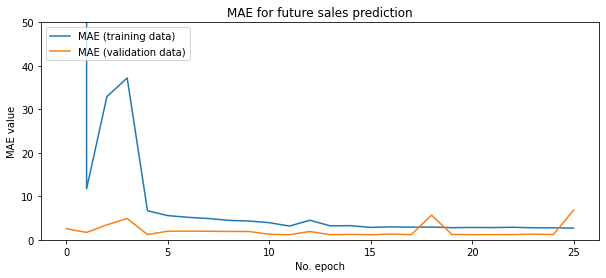

In [277]:
# Plot history: MAE
plt.figure(figsize = (10, 4))
plt.plot(history5.history['loss'], label='MAE (training data)')
plt.plot(history5.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for future sales prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim([0, 50])
plt.show()